# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$.
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки.
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вершину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии.

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):

    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер.

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения узлов дерева (используйте, например, `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
iris = datasets.load_iris()
class Tree:
    def __init__(self, depth, max_depth,max_leaves,min_objects_leaf):
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None
        self.min_objects_leaf = min_objects_leaf
        self.max_leaves = max_leaves
        self.feature = None
        self.class_predict = None
        self.threshold = None
        self.is_leaf = False

    def best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_score = -999

        for features in range(len(X.columns)):
            unique_values = np.unique(X.iloc[:, features])

            for value in unique_values:
                left = X.loc[X.iloc[:, features] < value]
                right = X.loc[X.iloc[:, features] >= value]

                IG = self.information_gain(left, right, y)

                if IG > best_score:
                    best_feature = features
                    best_threshold = value
                    best_score = IG

        return best_feature, best_threshold

    def information_gain(self, left, right, y):
        m = len(y)

        H_Rv = entropy(y)
        H_Rl = entropy(y.loc[left.index])
        H_Rr = entropy(y.loc[right.index])

        IG = H_Rv - (len(y.loc[left.index]) / m) * H_Rl - (len(y.loc[right.index]) / m) * H_Rr

        return IG

    def split(self, X, y):
        if self.depth >= self.max_depth or len(y) <= self.min_objects_leaf or self.max_leaves == 0 or len(y.unique()) == 1:
            self.is_leaf = True
            self.class_predict = y.mode()[0]
            return

        best_feature, best_threshold = self.best_split(X, y)

        if best_feature is not None:
            self.feature = best_feature
            self.threshold = best_threshold

            left = X.loc[X.iloc[:, best_feature] < best_threshold]
            right = X.loc[X.iloc[:, best_feature] >= best_threshold]

            self.update_tree()

            self.left.split(left, y.loc[left.index])
            self.right.split(right, y.loc[right.index])

    def update_tree(self):
        self.left = Tree(self.depth + 1, self.max_depth, self.max_leaves - 1, self.min_objects_leaf)
        self.right = Tree(self.depth + 1, self.max_depth, self.max_leaves - 1, self.min_objects_leaf)

    def fit(self, X, y):
        self.split(pd.DataFrame(X), pd.Series(y))


def predict(node, X):
    if node.is_leaf:
        return node.class_predict

    if X[node.feature] < node.threshold:
        return predict(node.left, X)
    else:
        return predict(node.right, X)

iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

tree = Tree(0, max_depth=5,max_leaves=5,min_objects_leaf=5)
tree.fit(X_train, y_train)

y_pred = [predict(tree, X) for X in X_test]

accuracy_sc = accuracy_score(y_test, y_pred)
print("Accuracy:" , accuracy_sc)

Accuracy: 0.96


In [ ]:
import pandas as pd

In [ ]:
y=pd.Series([0,0,0,1,1,2])

In [ ]:
y.mode()

0    0
dtype: int64

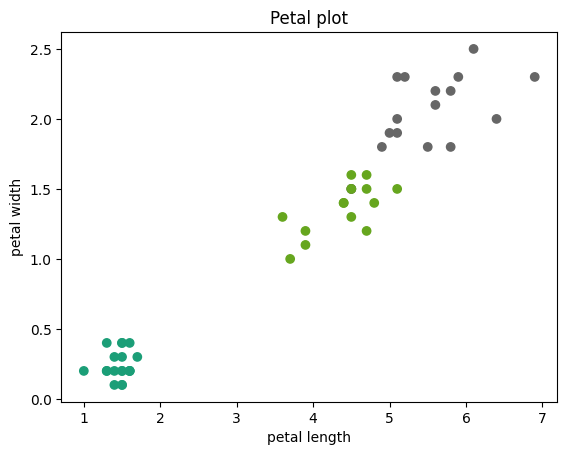

In [ ]:
plt.scatter(X_test[:, 2], X_test[:, 3], c=y_pred, cmap=plt.cm.Dark2)
plt.title('Petal plot')
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.show()

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
!gdown 1d-WeljXH8WMBdeKTqiP7e_fSpgLxa-z4

Downloading...
From: https://drive.google.com/uc?id=1d-WeljXH8WMBdeKTqiP7e_fSpgLxa-z4
To: /content/churn.csv
100% 685k/685k [00:00<00:00, 8.59MB/s]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

data=pd.read_csv(filepath_or_buffer = "churn.csv",
           sep = ',')
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])
X = data[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
          'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

def class_predict(trees, X):
    predictions = np.array([tree.predict(X) for tree in trees])
    return np.mean(predictions, axis=0)

def bootstrap_objects(X, y):
    index = np.random.choice(len(X), len(X), replace=True)
    return X.iloc[index], y.iloc[index]

def build_tree(X, y, max_depth=None, min_objects_leaf=1):
    tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_objects_leaf)
    tree.fit(X, y)
    return tree


def random_forest(X, y, count_trees, max_depth=None, min_objects_leaf=None):
    trees = []
    for _ in range(count_trees):
        X_object, y_object = bootstrap_objects(X, y)
        tree = build_tree(X_object, y_object, max_depth=max_depth, min_objects_leaf=min_objects_leaf)
        trees.append(tree)
    return trees


count_trees = 100
max_depth = 5
min_objects_leaf = 5

forest = random_forest(X_train, y_train, count_trees=count_trees, max_depth=max_depth, min_objects_leaf=min_objects_leaf)


y_pred_test = class_predict(forest, X_test)
accuracy_test = (y_pred_test == y_test).mean()
print("Точность test:", accuracy_test)
print(y_pred_test)

feature_importances = np.mean([tree.feature_importances_ for tree in forest], axis=0)
f_importance = pd.Series(feature_importances, index=X.columns)
print(f_importance)

Точность test: 0.7115
[0.   0.   0.   ... 0.91 0.   0.  ]
CreditScore        0.006465
Geography          0.006611
Gender             0.002421
Age                0.447042
Tenure             0.003273
Balance            0.035179
NumOfProducts      0.333808
HasCrCard          0.000104
IsActiveMember     0.153611
EstimatedSalary    0.011487
dtype: float64


In [ ]:
max_depth_range = [2, 5, 10]
count_trees_range = [50, 100, 200]
min_objects_leaf_range = [1, 5, 10]

best_accuracy = 0
best_max_depth = None
best_count_trees = None
best_min_objects_leaf = None


for max_depth in max_depth_range:
    for count_trees in count_trees_range:
        for min_objects_leaf in min_objects_leaf_range:
            forest = random_forest(X_train, y_train, count_trees=count_trees, max_depth=max_depth, min_objects_leaf=min_objects_leaf)
            y_pred_test = class_predict(forest, X_test)
            accuracy_test = (y_pred_test == y_test).mean()

            print(f"max_depth: {max_depth}, count_trees: {count_trees}, min_objects_leaf: {min_objects_leaf}, Accuracy: {accuracy_test}")

            if accuracy_test > best_accuracy:
                best_accuracy = accuracy_test
                best_max_depth = max_depth
                best_count_trees = count_trees
                best_min_objects_leaf = min_objects_leaf

print(f"Best parametrs: max_depth = {best_max_depth}, count_trees = {best_count_trees}, min_objects_leaf = {best_min_objects_leaf}")


max_depth: 2, count_trees: 50, min_objects_leaf: 1, Accuracy: 0.7225
max_depth: 2, count_trees: 50, min_objects_leaf: 5, Accuracy: 0.7535
max_depth: 2, count_trees: 50, min_objects_leaf: 10, Accuracy: 0.7535
max_depth: 2, count_trees: 100, min_objects_leaf: 1, Accuracy: 0.7535
max_depth: 2, count_trees: 100, min_objects_leaf: 5, Accuracy: 0.7535
max_depth: 2, count_trees: 100, min_objects_leaf: 10, Accuracy: 0.7535
max_depth: 2, count_trees: 200, min_objects_leaf: 1, Accuracy: 0.753
max_depth: 2, count_trees: 200, min_objects_leaf: 5, Accuracy: 0.6815
max_depth: 2, count_trees: 200, min_objects_leaf: 10, Accuracy: 0.7535
max_depth: 5, count_trees: 50, min_objects_leaf: 1, Accuracy: 0.741
max_depth: 5, count_trees: 50, min_objects_leaf: 5, Accuracy: 0.7355
max_depth: 5, count_trees: 50, min_objects_leaf: 10, Accuracy: 0.7335
max_depth: 5, count_trees: 100, min_objects_leaf: 1, Accuracy: 0.7315
max_depth: 5, count_trees: 100, min_objects_leaf: 5, Accuracy: 0.724
max_depth: 5, count_trees